In [5]:
from google.colab import files
uploaded = files.upload()

Saving quantum_dataset.csv to quantum_dataset (1).csv


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"   Using Device: {device}")

try:
    df = pd.read_csv("quantum_dataset.csv")
    print(f"Dataset Loaded: {len(df)} samples found")
except FileNotFoundError:
    print("not found")
    raise


In [ ]:
#Metadata (3) + Low Noise (16) + Mod Noise (16) + High Noise (16)
#Total Input Features = 51
input_cols = ["n_qubits", "n_gates", "depth"]
for level in ["low", "moderate", "high"]:
    for i in range(16):
        input_cols.append(f"{level}_{i}")

target_cols = [f"ideal_{i}" for i in range(16)]

X_numpy = df[input_cols].values.astype(np.float32)
Y_numpy = df[target_cols].values.astype(np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(X_numpy, Y_numpy, test_size=0.2, random_state=42)

X_train_gpu = torch.tensor(X_train).to(device)
Y_train_gpu = torch.tensor(Y_train).to(device)
X_test_gpu = torch.tensor(X_test).to(device)
Y_test_gpu = torch.tensor(Y_test).to(device)

print(f"   Training Data Shape: {X_train.shape}")
print(f"   Testing Data Shape:  {X_test.shape}")

In [7]:
class QuantumErrorMitigator(nn.Module):
    def __init__(self):
        super(QuantumErrorMitigator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(51, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 16),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)

model = QuantumErrorMitigator().to(device)
print("init model")

init model


In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
EPOCHS = 500

train_losses = []
test_losses = []

pbar = tqdm(range(EPOCHS))
for epoch in pbar:

    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_gpu)
    loss = criterion(predictions, Y_train_gpu)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_gpu)
        test_loss = criterion(test_pred, Y_test_gpu)
        test_losses.append(test_loss.item())
    if epoch %50 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.6f}")
    if epoch % 50 == 0:
        pbar.set_description(f"Epoch {epoch} | Loss: {loss.item():.6f}")

print(" Training Complete!")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | Loss: 0.004375
Epoch 50 | Loss: 0.004720
Epoch 100 | Loss: 0.004050
Epoch 150 | Loss: 0.003903
Epoch 200 | Loss: 0.003476
Epoch 250 | Loss: 0.003313
Epoch 300 | Loss: 0.003138
Epoch 350 | Loss: 0.002565
Epoch 400 | Loss: 0.002580
Epoch 450 | Loss: 0.002124
 Training Complete!


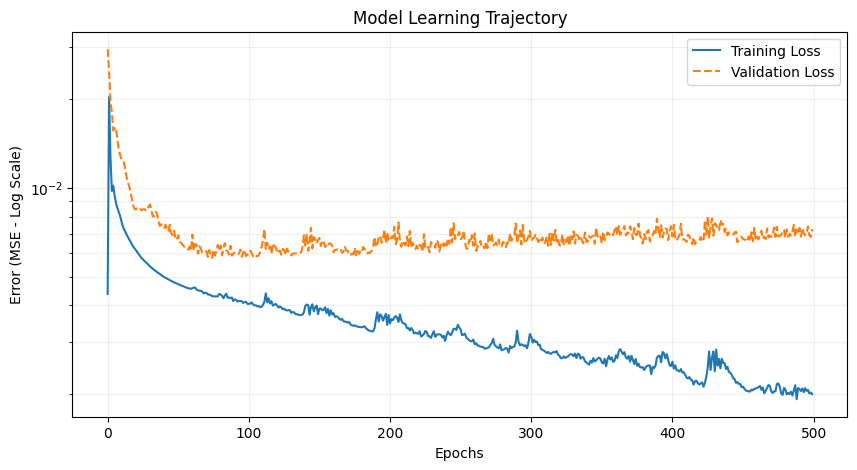

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss", linestyle="--")
plt.yscale('log') #makes small errors visible
plt.xlabel("Epochs")
plt.ylabel("Error (MSE - Log Scale)")
plt.title("Model Learning Trajectory")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

In [31]:
model.eval()
with torch.no_grad():
    all_preds = model(X_test_gpu)

Y_truth = Y_test_gpu.cpu().numpy()
Y_pred_ai = all_preds.cpu().numpy()

X_noisy_high = X_test_gpu[:, 35:].cpu().numpy()

#per sample (row-wise)
mse_unmitigated = ((Y_truth - X_noisy_high) ** 2).mean(axis=1)
mse_ai = ((Y_truth - Y_pred_ai) ** 2).mean(axis=1)

# Summary Stats
avg_noise_error = mse_unmitigated.mean()
avg_ai_error = mse_ai.mean()
improvement_factor = avg_noise_error / avg_ai_error
win_rate = np.sum(mse_ai < mse_unmitigated) / len(mse_ai) * 100

print(f"\nFINAL PERFORMANCE REPORT (Evaluated on {len(mse_ai)} Test Samples)")
print("=" * 60)
print(f"Average Error (Unmitigated): {avg_noise_error:.6f}")
print(f"Average Error (M Model):    {avg_ai_error:.6f}")
print("-" * 60)
print(f"Improvement Factor:       {improvement_factor:.2f}x (Signal is {improvement_factor:.1f} times cleaner)")
print(f"Win Rate:                 {win_rate:.2f}% of circuits improved")
print("=" * 60)



FINAL PERFORMANCE REPORT (Evaluated on 2000 Test Samples)
Average Error (Unmitigated): 0.022488
Average Error (M Model):    0.007256
------------------------------------------------------------
Improvement Factor:       3.10x (Signal is 3.1 times cleaner)
Win Rate:                 82.85% of circuits improved


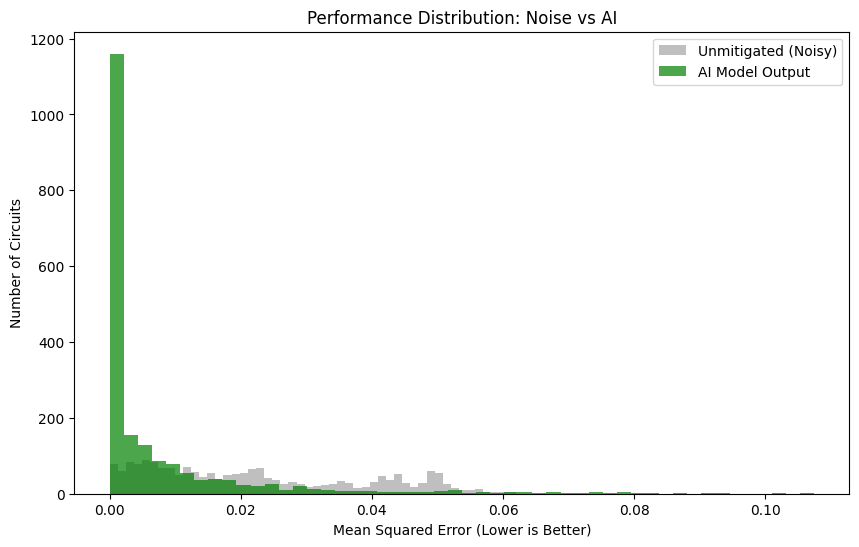


Detailed Check (First 5 Samples)
Metric               | Unmitigated          | AI Model            
-----------------------------------------------------------------
Sample 1 better     | 0.009686             | 0.007908
Sample 2 better     | 0.006657             | 0.000061
Sample 3 better     | 0.016821             | 0.000164
Sample 4 better     | 0.006933             | 0.000075
Sample 5 better     | 0.017550             | 0.001364


In [32]:

# error histo
plt.figure(figsize=(10, 6))
plt.hist(mse_unmitigated, bins=50, alpha=0.5, label='Unmitigated (Noisy)', color='gray')
plt.hist(mse_ai, bins=50, alpha=0.7, label='AI Model Output', color='green')
plt.xlabel('Mean Squared Error (Lower is Better)')
plt.ylabel('Number of Circuits')
plt.title('Performance Distribution: Noise vs AI')
plt.legend()
plt.show()

# Sample Check
print("\nDetailed Check (First 5 Samples)")
print(f"{'Metric':<20} | {'Unmitigated':<20} | {'AI Model':<20}")
print("-" * 65)
for i in range(5):
    status = "better" if mse_ai[i] < mse_unmitigated[i] else "not"
    print(f"Sample {i+1} {status}     | {mse_unmitigated[i]:.6f}             | {mse_ai[i]:.6f}")